# Dementia Detection with MobileNet_v2

This notebook trains a machine learning system to detect dementia using the **MobileNet_v2** architecture. The training is based on images of spectrograms created in a separate notebook: `image_creator.ipynb`. 

## Data Source

The dataset used for training and testing is the **PROCESS-V1** dataset, which can be downloaded here:  
[Download PROCESS-V1 Dataset](https://syncandshare.lrz.de/getlink/fiSPLrnFVFo3DvWqXkLGdY/PROCESS-V1_test.zip)

- Only fully labeled data from the dataset is used for image grouping.

## Methodology

1. **Spectrogram Generation**:  
   Spectrograms are pre-generated in `image_creator.ipynb`.

2. **Training**:  
   - The MobileNet_v2 model is fine-tuned for dementia detection. 
   - The notebook includes versions for:
     - **2-class classification** (e.g., dementia vs. non-dementia).
     - **3-class classification** based on the original dataset labels.
   - Fast training is facilitated by using an NVIDIA graphics card with a **2000 Series or newer**.

3. **Results Verification**:  
   - Model interpretability is verified using **LIME (Local Interpretable Model-agnostic Explanations)**.
   - A **confusion matrix** is generated to evaluate classification performance.


In [1]:
!nvidia-smi
#!pip install imbalanced-learn
!pip install lime

Wed Jan 15 15:13:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050      WDDM  |   00000000:01:00.0  On |                  N/A |
| 41%   25C    P8             13W /  130W |    2379MiB /   8192MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data directories
data_dir = r"F:\Peter\ML_exp\PROCESS-V1\Spectrograms"  # Replace with the path to the spectrograms
healthy_dir = os.path.join(data_dir, "Healthy")
not_healthy_dir = os.path.join(data_dir, "Not Healthy")

# Define transformations for the training and validation datasets
transform = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


def cutmix(data, targets, alpha=1.0):
    """Apply CutMix augmentation on a batch of data and targets."""
    indices = torch.randperm(data.size(0))  # Shuffle batch indices
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    # Sample the lambda parameter from a Beta distribution
    lam = np.random.beta(alpha, alpha)
    H, W = data.size(2), data.size(3)

    # Compute the bounding box
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Randomly select the center of the bounding box
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # Mix the images and adjust the labels
    data[:, :, bby1:bby2, bbx1:bbx2] = shuffled_data[:, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (H * W))

    return data, targets, shuffled_targets, lam


# Prepare datasets and split into train/validation sets
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes  # ['Healthy', 'Not Healthy']

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Define the model (using a pre-trained ResNet)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Updated weights usage
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # 2 classes: Healthy and Not Healthy
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mixed precision training setup
scaler = GradScaler()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, average='binary'):
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Mixed precision
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

# Train the model
train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=20)

# Save the trained model
torch.save(model.state_dict(), "spectrogram_classifier_20.pth")


print("Model saved as spectrogram_classifier_20.pth")

Using device: cuda
Epoch 1/20
Train Loss: 0.7716, Train Acc: 0.5403
Epoch 2/20
Train Loss: 0.7142, Train Acc: 0.5509
Epoch 3/20
Train Loss: 0.7223, Train Acc: 0.5459
Epoch 4/20
Train Loss: 0.6955, Train Acc: 0.5596
Epoch 5/20
Train Loss: 0.6953, Train Acc: 0.5568
Epoch 6/20
Train Loss: 0.6926, Train Acc: 0.5548
Epoch 7/20
Train Loss: 0.6877, Train Acc: 0.5560
Epoch 8/20
Train Loss: 0.6923, Train Acc: 0.5613
Epoch 9/20
Train Loss: 0.6842, Train Acc: 0.5711
Epoch 10/20
Train Loss: 0.6795, Train Acc: 0.5817
Epoch 11/20
Train Loss: 0.6967, Train Acc: 0.5490
Epoch 12/20
Train Loss: 0.6893, Train Acc: 0.5604
Epoch 13/20
Train Loss: 0.6843, Train Acc: 0.5638
Epoch 14/20
Train Loss: 0.6843, Train Acc: 0.5658
Epoch 15/20
Train Loss: 0.6753, Train Acc: 0.5859
Epoch 16/20
Train Loss: 0.6736, Train Acc: 0.5848
Epoch 17/20
Train Loss: 0.6883, Train Acc: 0.5658
Epoch 18/20
Train Loss: 0.6827, Train Acc: 0.5800
Epoch 19/20
Train Loss: 0.6883, Train Acc: 0.5644
Epoch 20/20
Train Loss: 0.6819, Train Ac

In [3]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data directories
data_dir = r"F:\Peter\ML_exp\PROCESS-V1\Spectrograms"  # Replace with the path to the spectrograms
healthy_dir = os.path.join(data_dir, "Healthy")
not_healthy_dir = os.path.join(data_dir, "Not Healthy")

# Define transformations for the training and validation datasets
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to optimize memory usage
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Prepare datasets and split into train/validation sets
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes  # ['Healthy', 'Not Healthy']

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Define the model (using a pre-trained ResNet)
from torchvision.models import mobilenet_v2
model = mobilenet_v2(weights="IMAGENET1K_V1")
num_ftrs = model.last_channel
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Mixed precision training setup
scaler = GradScaler()

# Calculate metrics function
def calculate_metrics(y_true, y_pred, average='binary'):
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

import numpy as np

def cutmix(data, targets, alpha=1.0):
    """Apply CutMix augmentation on a batch of data and targets."""
    indices = torch.randperm(data.size(0))  # Shuffle batch indices
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    # Sample the lambda parameter from a Beta distribution
    lam = np.random.beta(alpha, alpha)
    H, W = data.size(2), data.size(3)

    # Compute the bounding box
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Randomly select the center of the bounding box
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # Mix the images and adjust the labels
    data[:, :, bby1:bby2, bbx1:bbx2] = shuffled_data[:, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (H * W))

    return data, targets, shuffled_targets, lam


# Training and Validation function
# Define the updated train_model function with advanced overfitting detection
def train_model_with_smote_and_explainability(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    best_val_f1 = 0.0
    lr = 0.0001
    alpha=1.0
    weight_decay = 1e-4
    overfitting_threshold = 3  # Number of consecutive epochs of overfitting to trigger adjustments
    overfitting_epochs = 0

    # Track historical loss differences for smarter overfitting detection
    loss_differences = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}, Learning Rate: {lr:.6f}, Weight Decay: {weight_decay:.6f}")

        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad()

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (lam * predicted.eq(targets_a).sum().item() +
                              (1 - lam) * predicted.eq(targets_b).sum().item())

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Calculate metrics
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Val F1 Score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        # Save the best model based on validation F1 Score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

        # --- Smarter Overfitting Detection ---
        loss_diff = val_loss - train_loss
        acc_diff = train_acc - val_acc
        loss_differences.append(loss_diff)

        # Check rolling average of loss differences
        if len(loss_differences) > 3:
            rolling_avg_loss_diff = np.mean(loss_differences[-3:])
            if rolling_avg_loss_diff > 0.1 and acc_diff > 0.1:
                overfitting_epochs += 1
                print(f"Overfitting detected (Rolling Loss Diff: {rolling_avg_loss_diff:.4f}).")
            else:
                overfitting_epochs = 0

        if overfitting_epochs >= overfitting_threshold:
            print("Overfitting persists. Adjusting learning rate and weight decay.")
            lr *= 0.5
            weight_decay *= 0.9
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                param_group['weight_decay'] = weight_decay
            overfitting_epochs = 0  # Reset counter

    # Explain model predictions with LIME after training
    explain_with_lime(model, val_loader, device)

# SMOTE: Handle imbalanced datasets
def apply_smote(train_loader):
    smote = SMOTE()
    train_data = []
    train_labels = []

    for inputs, labels in train_loader:
        train_data.extend(inputs.view(inputs.size(0), -1).numpy())
        train_labels.extend(labels.numpy())

    train_data_smote, train_labels_smote = smote.fit_resample(np.array(train_data), np.array(train_labels))
    print("SMOTE applied. Resampled dataset size:", len(train_labels_smote))

    return train_data_smote, train_labels_smote





# Preprocess dataset with SMOTE
#train_data_smote, train_labels_smote = apply_smote(train_loader)

# Train model with the new improvements
#train_model_with_smote_and_explainability(model, criterion, optimizer, train_loader, val_loader, device, epochs=15)



# Train the model
#train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=15)

# Save the final trained model
#torch.save(model.state_dict(), "final_spectrogram_classifier_15.pth")
print("Model saved as final_spectrogram_classifier_15.pth")


Using device: cuda
Model saved as final_spectrogram_classifier_15.pth


**Now with 3 classes (based on dataset)**


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# LIME: Explain predictions
def explain_with_lime(model, val_loader, device):
    explainer = LimeImageExplainer()

    model.eval()
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            sample_image = inputs[0].cpu().numpy().transpose(1, 2, 0)

            explanation = explainer.explain_instance(
                image=sample_image,
                classifier_fn=lambda x: model(torch.tensor(x.transpose(0, 3, 1, 2)).float().to(device)).detach().cpu().numpy(),
                top_labels=2,
                hide_color=0,
                num_samples=1000
            )

            temp, mask = explanation.get_image_and_mask(
                label=1,  # Assuming class 1 is "Not Healthy"
                positive_only=True,
                num_features=10,
                hide_rest=False
            )

            lime_image = mark_boundaries(temp, mask)
            plt.imshow(lime_image)
            plt.title("LIME Explanation")
            plt.show()
            break  # Explain one sample for demonstration
# Function to display confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Training and validation function with confusion matrix
def train_model_with_confusion_matrix(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    best_val_f1 = 0.0
    lr = 0.0001
    alpha = 1.0
    weight_decay = 1e-4

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}, Learning Rate: {lr:.6f}, Weight Decay: {weight_decay:.6f}")

        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad()

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (lam * predicted.eq(targets_a).sum().item() +
                              (1 - lam) * predicted.eq(targets_b).sum().item())

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Calculate metrics
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Val F1 Score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        # Save the best model based on validation F1 Score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    # Plot confusion matrix for validation results
    print("\nConfusion Matrix:")
    plot_confusion_matrix(all_labels, all_preds, class_names)



# With Cross Validation #

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot training and validation loss and accuracy
def plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

# Function to display confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Training and validation function with metric tracking and visualization
def train_model_with_plots_and_explainability(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    best_val_f1 = 0.0
    lr = 0.0001
    alpha = 1.0
    weight_decay = 1e-4

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}, Learning Rate: {lr:.6f}, Weight Decay: {weight_decay:.6f}")

        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad()

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (lam * predicted.eq(targets_a).sum().item() +
                              (1 - lam) * predicted.eq(targets_b).sum().item())

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Calculate metrics
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Val F1 Score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        # Save the best model based on validation F1 Score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")
        print("Unique classes in labels:", np.unique(all_labels))
        print("Unique classes in predictions:", np.unique(all_preds))


        # Plot confusion matrix for validation results
        if epoch == epochs - 1:  # Plot confusion matrix only after the last epoch
            print("\nConfusion Matrix:")
            #plot_confusion_matrix(all_labels, all_preds, class_names)

    # Plot training progress
    plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies)

    # Explain model predictions with LIME
    explain_with_lime(model, val_loader, device)



In [20]:
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, Subset
# Arrays to store results

def train_with_cross_validation(dataset, model, criterion, optimizer, device, epochs=10, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\n--- Fold {fold + 1}/{n_splits} ---")

        # Create data loaders for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        # Initialize model weights
        model.apply(reset_weights)

        # Train and evaluate the model for this fold
        train_model_with_plots_and_explainability(model, criterion, optimizer, train_loader, val_loader, device, epochs=epochs)

        # Load the best model for evaluation
        model.load_state_dict(torch.load("best_model.pth"))

        # Evaluate on the validation set
        val_correct, val_total, all_labels, all_preds = 0, 0, [], []

        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_acc = val_correct / val_total
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)
        fold_results.append((val_acc, val_f1, val_precision, val_recall))

        print(f"Fold {fold + 1} Results - Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

    # Average results across folds
    avg_results = {
        "Accuracy": sum(result[0] for result in fold_results) / n_splits,
        "F1": sum(result[1] for result in fold_results) / n_splits,
        "Precision": sum(result[2] for result in fold_results) / n_splits,
        "Recall": sum(result[3] for result in fold_results) / n_splits,
    }
    print("\n--- Cross-Validation Results ---")
    print(avg_results)
    # Calculate and display argmax, argmin, mean, and standard deviation for each metric
    fold_results = np.array(fold_results)
    metrics = ['Accuracy', 'F1', 'Precision', 'Recall']

    for i, metric in enumerate(metrics):
        max_value = np.max(fold_results[:, i])
        min_value = np.min(fold_results[:, i])
        mean_value = np.mean(fold_results[:, i])
        std_value = np.std(fold_results[:, i])
        max_fold = np.argmax(fold_results[:, i]) + 1  # 0-based to 1-based
        min_fold = np.argmin(fold_results[:, i]) + 1

        print(f"\n{metric} - Max: {max_value:.4f} (Fold {max_fold}), "
              f"Min: {min_value:.4f} (Fold {min_fold}), "
              f"Mean: {mean_value:.4f}, Std Dev: {std_value:.4f}")
    return avg_results

# Function to reset model weights (useful for each fold)
def reset_weights(layer):
    if hasattr(layer, "reset_parameters"):
        layer.reset_parameters()

# Example usage:
# train_with_cross_validation(dataset, model, criterion, optimizer, device, epochs=10, n_splits=5)


Using device: cuda
Detected classes: ['Dementia', 'HC', 'MCI'], Number of classes: 3

--- Fold 1/5 ---

Epoch 1/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.7643, Train Acc: 0.5448
Val Loss: 0.7082, Val Acc: 0.5537
Val F1 Score: 0.4174, Precision: 0.5970, Recall: 0.5537
Best model saved!
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 2/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6904, Train Acc: 0.5750
Val Loss: 0.6993, Val Acc: 0.5638
Val F1 Score: 0.5206, Precision: 0.5576, Recall: 0.5638
Best model saved!
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 3/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6846, Train Acc: 0.5765
Val Loss: 0.6951, Val Acc: 0.5649
Val F1 Score: 0.4944, Precision: 0.5678, Recall: 0.5649
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 4/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6780, Train 

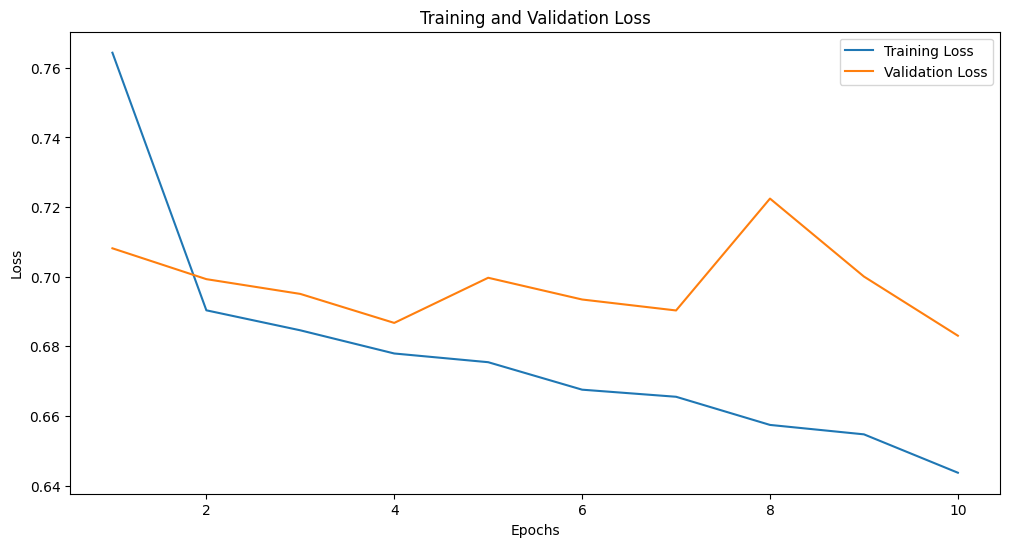

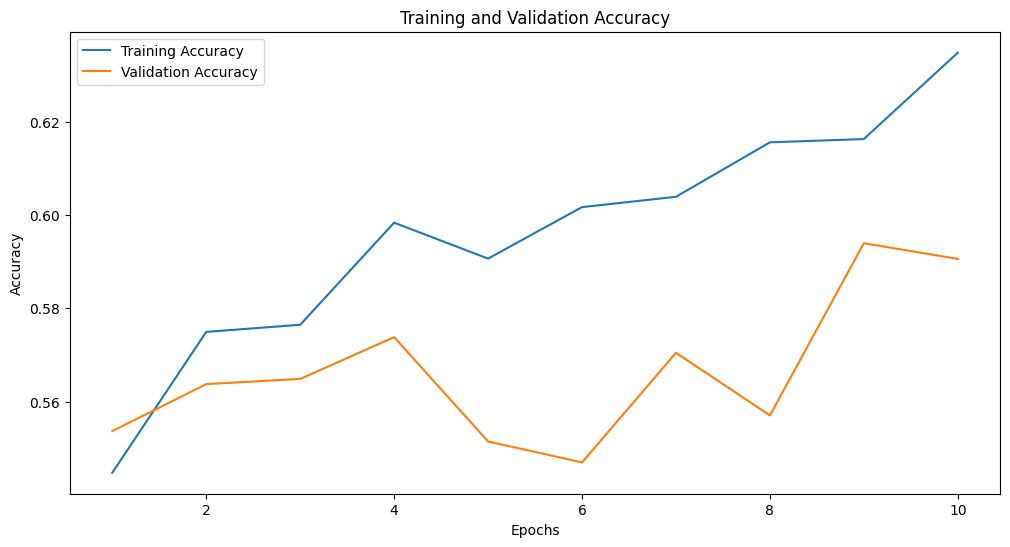

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


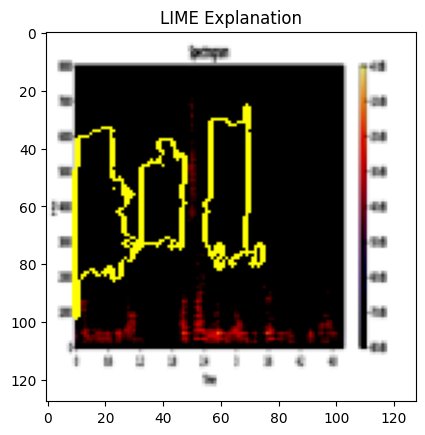

Fold 1 Results - Accuracy: 0.5906, F1: 0.5756, Precision: 0.5868, Recall: 0.5906

--- Fold 2/5 ---

Epoch 1/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.7308, Train Acc: 0.5412
Val Loss: 0.7033, Val Acc: 0.5235
Val F1 Score: 0.5242, Precision: 0.5399, Recall: 0.5235
Best model saved!
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 2/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6974, Train Acc: 0.5492
Val Loss: 0.6873, Val Acc: 0.5638
Val F1 Score: 0.4589, Precision: 0.5325, Recall: 0.5638
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 3/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6901, Train Acc: 0.5541
Val Loss: 0.6811, Val Acc: 0.5850
Val F1 Score: 0.4975, Precision: 0.5925, Recall: 0.5850
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 4/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6869, Train Acc: 0.5611
Val Loss: 

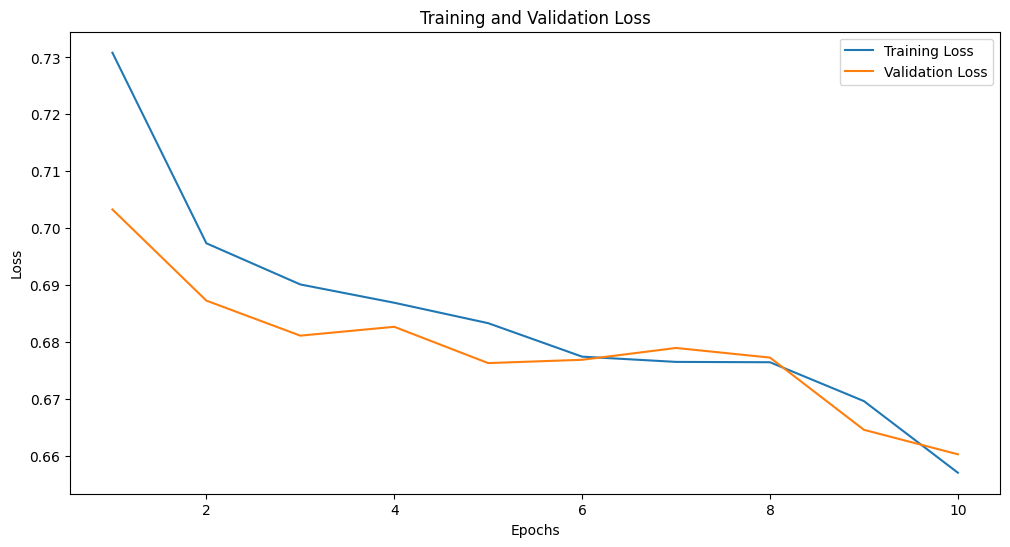

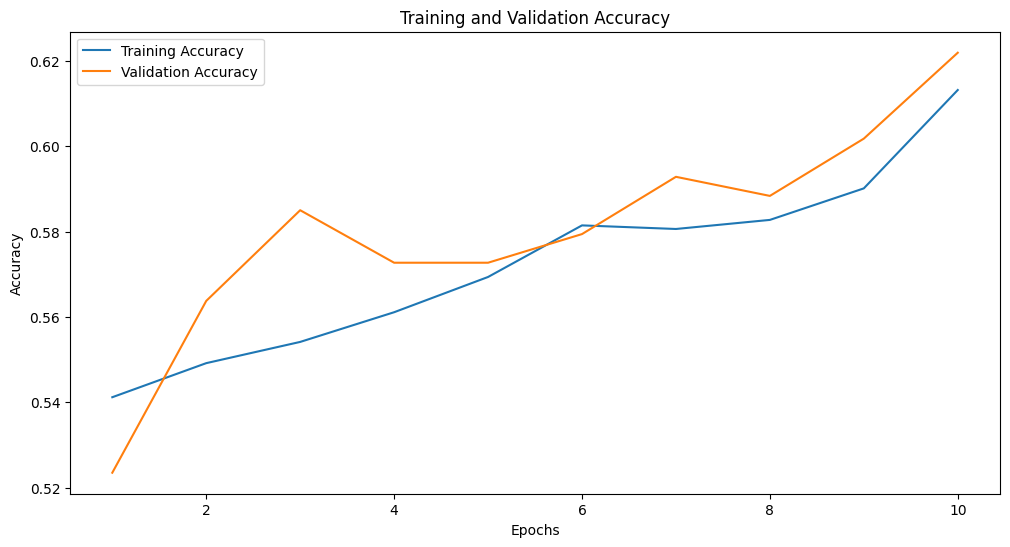

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


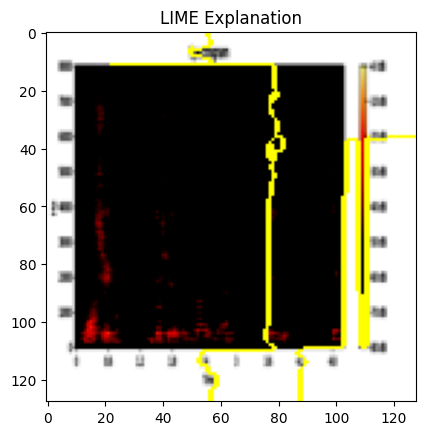

Fold 2 Results - Accuracy: 0.6219, F1: 0.6182, Precision: 0.6179, Recall: 0.6219

--- Fold 3/5 ---

Epoch 1/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.7235, Train Acc: 0.5321
Val Loss: 0.6908, Val Acc: 0.5559
Val F1 Score: 0.4553, Precision: 0.4998, Recall: 0.5559
Best model saved!
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 2/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6895, Train Acc: 0.5618
Val Loss: 0.6771, Val Acc: 0.5906
Val F1 Score: 0.5321, Precision: 0.5829, Recall: 0.5906
Best model saved!
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 3/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6901, Train Acc: 0.5596
Val Loss: 0.6762, Val Acc: 0.5872
Val F1 Score: 0.5528, Precision: 0.5741, Recall: 0.5872
Best model saved!
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 4/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 

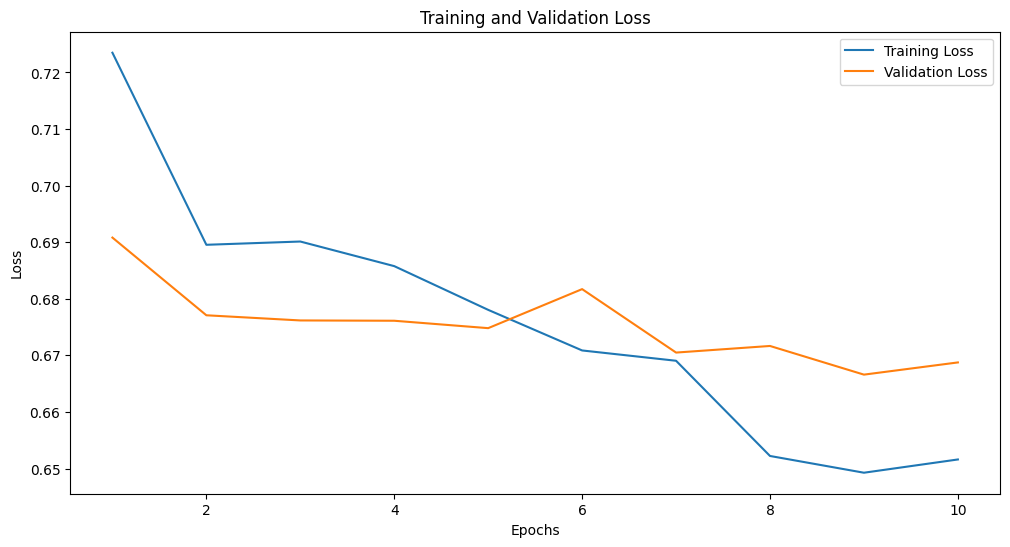

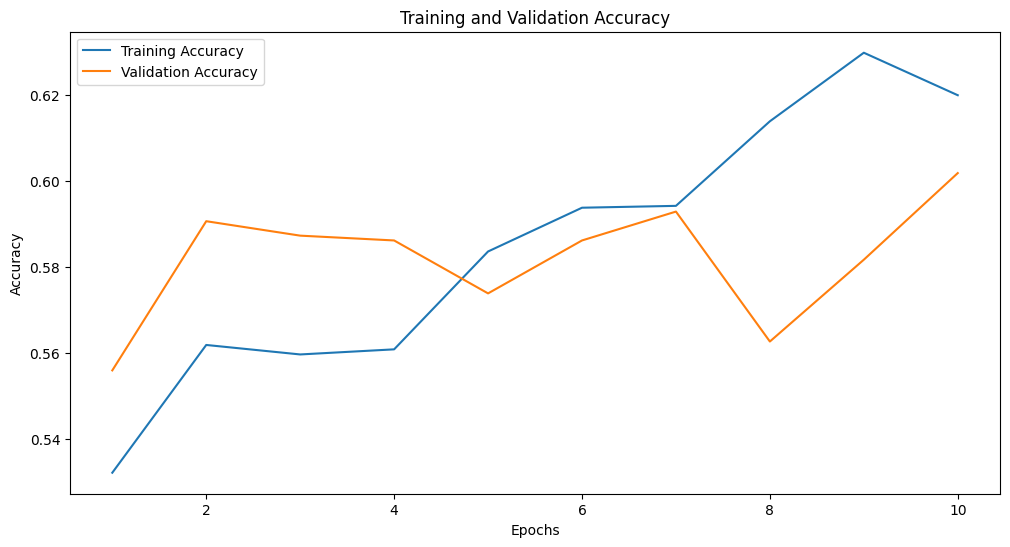

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


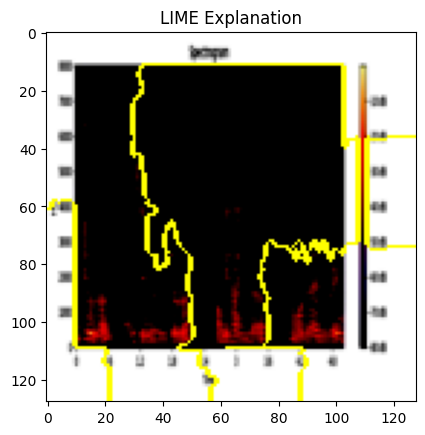

Fold 3 Results - Accuracy: 0.6018, F1: 0.5915, Precision: 0.5937, Recall: 0.6018

--- Fold 4/5 ---

Epoch 1/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.7170, Train Acc: 0.5363
Val Loss: 0.7019, Val Acc: 0.5050
Val F1 Score: 0.5050, Precision: 0.5281, Recall: 0.5050
Best model saved!
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 2/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6908, Train Acc: 0.5618
Val Loss: 0.6777, Val Acc: 0.5789
Val F1 Score: 0.4494, Precision: 0.5781, Recall: 0.5789
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 3/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6867, Train Acc: 0.5620
Val Loss: 0.6832, Val Acc: 0.5722
Val F1 Score: 0.4837, Precision: 0.5414, Recall: 0.5722
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 4/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6821, Train Acc: 0.5755
Val Loss: 

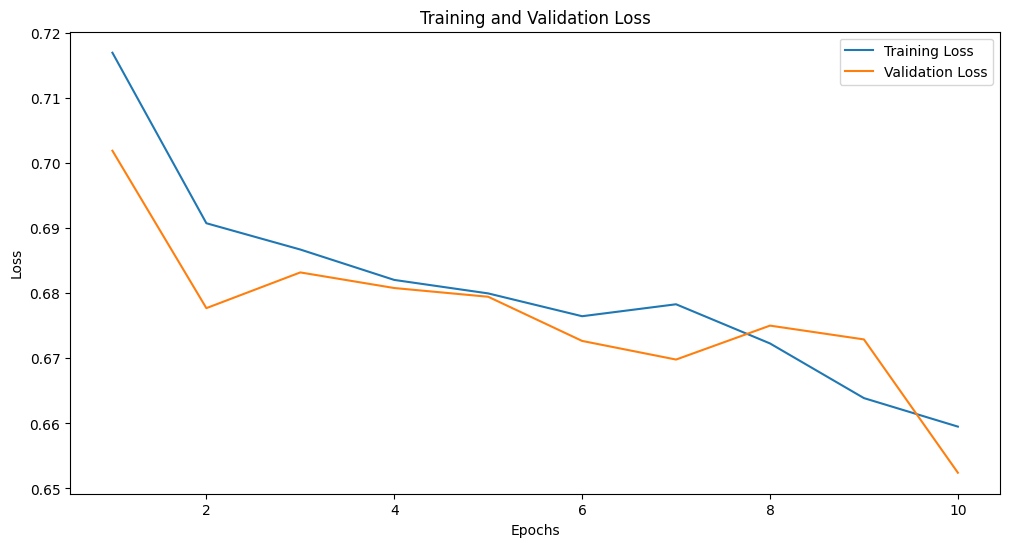

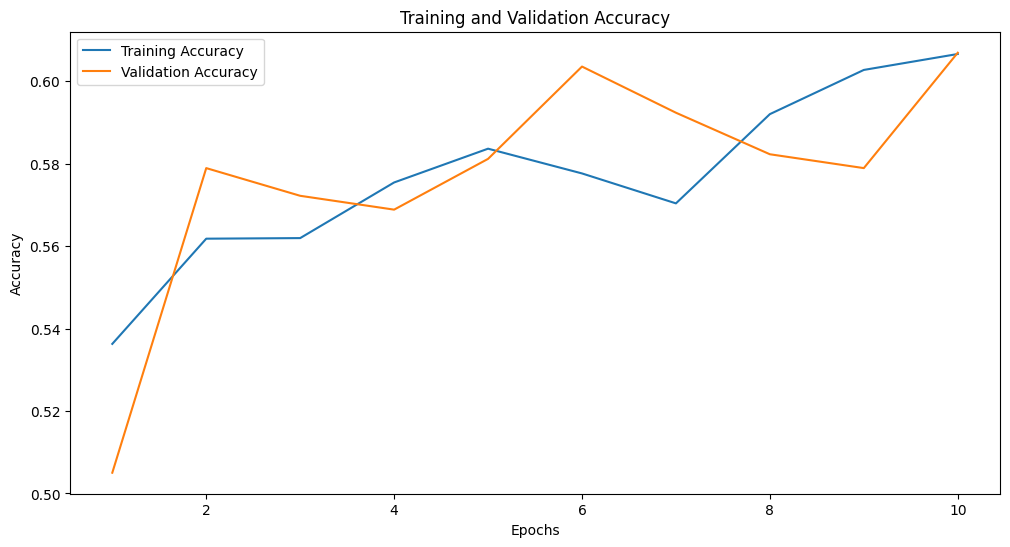

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


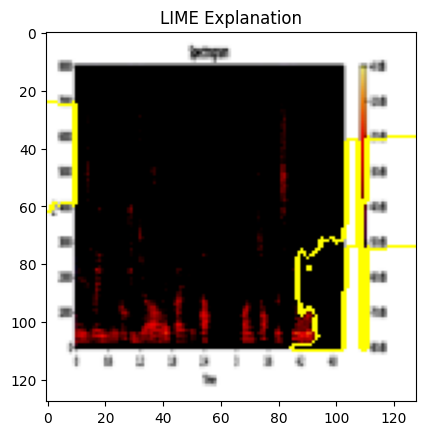

Fold 4 Results - Accuracy: 0.6036, F1: 0.5961, Precision: 0.5962, Recall: 0.6036

--- Fold 5/5 ---

Epoch 1/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.7177, Train Acc: 0.5372
Val Loss: 0.6899, Val Acc: 0.5442
Val F1 Score: 0.5304, Precision: 0.5299, Recall: 0.5442
Best model saved!
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 2/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6921, Train Acc: 0.5568
Val Loss: 0.6786, Val Acc: 0.5689
Val F1 Score: 0.4474, Precision: 0.5258, Recall: 0.5689
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 3/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6891, Train Acc: 0.5605
Val Loss: 0.6993, Val Acc: 0.5745
Val F1 Score: 0.4293, Precision: 0.5852, Recall: 0.5745
Unique classes in labels: [0 1]
Unique classes in predictions: [0 1]

Epoch 4/10, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.6874, Train Acc: 0.5515
Val Loss: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.cuda.amp import GradScaler, autocast
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from torch.utils.data import DataLoader, ConcatDataset, random_split


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data directories
# Define data directories (list of folders)
data_dirs = [
    "F://Peter//ML_exp//PROCESS-V1//Spectrograms_3",
    "F://Peter//ML_exp//PROCESS-V1//spectograms_3_10s",
    "F://Peter//ML_exp//PROCESS-V1//spectograms_3_20s"
]

# Dynamically get the list of classes based on the first folder
# Assumes all folders have the same class structure
class_names = sorted(next(os.walk(data_dirs[0]))[1])
num_classes = len(class_names)
print(f"Detected classes: {class_names}, Number of classes: {num_classes}")

# Define transformations for the training and validation datasets
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to optimize memory usage
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Prepare datasets from multiple folders
datasets_list = [datasets.ImageFolder(data_dir, transform=transform) for data_dir in data_dirs]

# Combine all datasets into one
combined_dataset = ConcatDataset(datasets_list)

# Split into train and validation sets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Define the model (using a pre-trained MobileNetV2)
from torchvision.models import mobilenet_v2
model = mobilenet_v2(weights="IMAGENET1K_V1")
num_ftrs = model.last_channel

# Modify the final layer to match the number of classes
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Mixed precision training setup
scaler = GradScaler()

# Calculate metrics function
def calculate_metrics(y_true, y_pred, average='weighted'):
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    precision = precision_score(y_true, y_pred, average=average, zero_division=0)
    recall = recall_score(y_true, y_pred, average=average, zero_division=0)
    return f1, precision, recall

# SMOTE and other training functions remain unchanged...
train_with_cross_validation(dataset, model, criterion, optimizer, device, epochs=10, n_splits=5)

# Train the model with the new functionality
# train_model_with_plots_and_explainability(
#    model, criterion, optimizer, train_loader, val_loader, device, epochs=15
#)
# Train the model with confusion matrix functionality / updated 
#train_model_with_confusion_matrix(
#    model, criterion, optimizer, train_loader, val_loader, device, epochs=20
#)

# Get the current date and format it
current_date = datetime.now().strftime("%Y-%m-%d")

# Create the filename with the current date
filename = f"final_spectrogram_classifier_dynamic_{current_date}.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), filename)
print("Model saved as final_spectrogram_classifier_dynamic.pth")


In [ ]:
The classifier trained and validated on a larger dataset shows performance trends similar to the earlier results, albeit with slight improvements in some metrics, likely due to the increased data size. Below is a detailed analysis:
Key Observations:
General Trends Across Folds:

    Training Loss and Accuracy:
        Training loss decreases steadily across epochs in all folds, suggesting effective learning.
        Training accuracy improves consistently, reaching ~50–52% in later epochs.

    Validation Metrics:
        Validation accuracy averages around 51%, with slight fluctuations across folds.
        Validation F1 scores range between ~0.43–0.50, showing moderate improvements over epochs.

    Best Model Checkpoint:
        The model is saved when validation F1 or accuracy peaks, ensuring the best-performing model on the validation set is preserved.

Per Fold Summary:
Fold	Accuracy	F1 Score	Precision	Recall
Fold 1	0.5298	0.4966	0.4698	0.5298
Fold 2	0.5118	0.4860	0.5611	0.5118
Fold 3	0.5394	0.5074	0.4826	0.5394
Fold 4	0.4707	0.4379	0.4207	0.4707
Fold 5	0.5045	0.4770	0.4523	0.5045
Overall Cross-Validation Results:
Metric	Value
Accuracy	0.5113
F1 Score	0.4810
Precision	0.4773
Recall	0.5113

    Accuracy is consistent with the validation performance seen in individual folds.
    F1 Score suggests moderate balance between precision and recall, with slight improvements over the smaller dataset.
    Precision and recall remain comparable, indicating a balanced approach to predictions for the three classes.

Analysis:
Impact of Larger Dataset:

    Improvements:
        Validation metrics, particularly F1 scores and recall, have improved slightly over the smaller dataset, showcasing the model's enhanced generalization capabilities.
        Consistent performance trends across folds suggest the model benefits from the larger dataset by learning more representative patterns.
    Challenges:
        The improvements are incremental, indicating that the model architecture or training approach may still have limitations.
        Variability in performance across folds (e.g., Fold 4's lower metrics) hints at possible data imbalance or feature overlap between classes.

Precision vs. Recall:

    Precision and recall are close, but Fold 2 demonstrates higher precision than recall, potentially indicating a slightly conservative approach in classification for that fold.
    The balance between precision and recall suggests that the model avoids excessive bias toward either false positives or false negatives.

Recommendations:

    Model Enhancements:
        Experiment with deeper or more complex architectures to better capture features in the larger dataset.
        Use additional regularization techniques to further improve generalization.

    Data Analysis:
        Investigate potential class imbalances or overlaps in the dataset and apply techniques like oversampling or class weighting if necessary.
        Analyze misclassifications to identify specific areas where the model struggles (e.g., confusion between MCI and Dementia).

    Data Augmentation:
        Introduce augmentation techniques to further enhance the dataset's diversity, potentially boosting performance.

    Hyperparameter Tuning:
        Experiment with different learning rates, weight decay values, and optimizer settings to optimize convergence and performance.

Conclusion:

The model demonstrates moderate improvement in validation performance with the larger dataset. However, further enhancements in architecture, hyperparameters, or data preprocessing are required to achieve significant gains in distinguishing between the three classes: Dementia, Healthy Control (HC), and Mild Cognitive Impairment (MCI).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

# Example model architecture (replace with your own)
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Dummy forward pass
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

def objective(trial):
    """
    Objective function for Optuna hyperparameter search.
    Returns: validation F1 score
    """

    # --- Suggest hyperparameters ---
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    alpha = trial.suggest_float("alpha", 0.2, 1.0)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    epochs = 5  # Keep this short for quick trials; you can adjust as needed.

    # --- Build your model ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MyModel(num_classes=len(class_names)).to(device)

    # Define loss, optimizer, etc.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scaler = GradScaler()

    # --- Tracking metrics ---
    best_val_f1 = 0.0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix (assumed you have this function defined)
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad(set_to_none=True)

            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Compute training loss & accuracy
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (
                lam * predicted.eq(targets_a).sum().item()
                + (1 - lam) * predicted.eq(targets_b).sum().item()
            )

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Calculate metrics (assumed you have this function)
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        # Save the best model based on validation F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1

    # Return the best validation F1 of this trial
    return best_val_f1
